In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os 
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
pip install tensorflow

In [29]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.16.1


In [30]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 50000


In [31]:
# reading dataset
df = pd.read_csv('topical_chat.csv')
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [32]:
# basic preprocessing
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text

In [33]:
df.message = df.message.apply(process)

In [34]:
df.head()

,conversation_id,message,sentiment
0,1,are you a fan of google or microsoft,Curious to dive deeper
1,1,both are excellent technology they are helpful...,Curious to dive deeper
2,1,im not a huge fan of google but i use it a lot...,Curious to dive deeper
3,1,google provides online related services and pr...,Curious to dive deeper
4,1,yeah their services are good im just not a fan...,Curious to dive deeper


In [35]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words_set = set()
target_words_set = set()

for conversation_index in tqdm(range(df.shape[0])):
    
    if conversation_index == 0:
        continue
        
    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]
    
    if input_text.conversation_id == target_text.conversation_id:
        
        input_text = input_text.message
        target_text = target_text.message
        
        if len(input_text.split()) > 2 and \
            len(target_text.split()) > 0 and \
            len(input_text.split()) < 30 and \
            len(target_text.split()) < 10 and \
            input_text and \
            target_text:
            
            target_text = "bos " + target_text + " eos"
                
            input_texts.append(input_text)
            target_texts.append(target_text)
            
            for word in input_text.split():
                if word not in input_words_set:
                    input_words_set.add(word)
            for word in target_text.split():
                if word not in target_words_set:
                    target_words_set.add(word)

100%|██████████████████████████████████████████████████████████████████████████| 50188/50188 [00:08<00:00, 5664.32it/s]


In [36]:
input_words = sorted(list(input_words_set))
target_words = sorted(list(target_words_set))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt.split()) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

#saving
with open('input_token_index.pickle', 'wb') as handle:
    pickle.dump(input_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#saving
with open('target_token_index.pickle', 'wb') as handle:
    pickle.dump(target_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

Number of samples: 5400
Number of unique input tokens: 6816
Number of unique output tokens: 3823
Max sequence length for inputs: 29
Max sequence length for outputs: 11


In [37]:
embedding_size = 100

# seq2seq model - https://keras.io/examples/nlp/lstm_seq2seq/
with strategy.scope():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None,))
    
    encoder_embedding_output = keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
                                               
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embedding_output)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None,))
    
    decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size)
    decoder_embedding_output = decoder_embedding(decoder_inputs)
    

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, None, 100)         │         681,600 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, None, 100)         │         382,300 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ [(None, 512), (None,      │       1,255,424 │ embedding_2[0][0]          │
│                               │ 512), (None, 512)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ [(None, None, 512),       │       1,255,424 │ embedding_3[0][0],         │
│                               │ (None, 512), (None, 512)] │                 │ lstm_2[0][1], lstm_2[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, None, 3823)        │       1,961,199 │ lstm_3[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,535,947 (21.12 MB)

 Trainable params: 5,535,947 (21.12 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu ban đầu thành train + validation và test set
encoder_input_data_train, encoder_input_data_test, decoder_input_data_train, decoder_input_data_test, decoder_target_data_train, decoder_target_data_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)




In [39]:
# Tiếp tục chia train set thành train và validation set
encoder_input_data_train, encoder_input_data_val, decoder_input_data_train, decoder_input_data_val, decoder_target_data_train, decoder_target_data_val = train_test_split(
    encoder_input_data_train, decoder_input_data_train, decoder_target_data_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [40]:
# Huấn luyện mô hình với train set và validation set
history = model.fit(
    [encoder_input_data_train, decoder_input_data_train],
    decoder_target_data_train,
    batch_size=batch_size,
    epochs=0,
    validation_data=([encoder_input_data_val, decoder_input_data_val], decoder_target_data_val),
)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.0974 - loss: 4.5507 - val_accuracy: 0.1102 - val_loss: 3.8966
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.1122 - loss: 3.8108 - val_accuracy: 0.1133 - val_loss: 3.8816
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.1124 - loss: 3.7069 - val_accuracy: 0.1141 - val_loss: 3.8531
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.1130 - loss: 3.6903 - val_accuracy: 0.1177 - val_loss: 3.8034
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.1166 - loss: 3.6434 - val_accuracy: 0.1210 - val_loss: 3.7650
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.1210 - loss: 3.5286 - val_accuracy: 0.1284 - val_loss: 3.7190
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.1305 - loss: 3.5075 - val_accuracy: 0.1431 - val_loss: 3.6730
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.1422 - loss: 3.4249 - val_accu

In [41]:
test_loss, test_accuracy = model.evaluate(
    [encoder_input_data_test, decoder_input_data_test],
    decoder_target_data_test
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1833 - loss: 3.5195
Test Loss: 3.4789090156555176, Test Accuracy: 0.17954547703266144


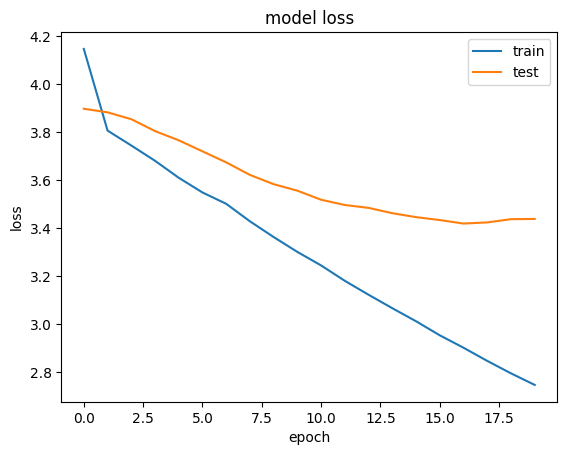

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [43]:
# Save model
model.save("s2s.hdf5")

In [44]:
# define the encoder model 
encoder_model = keras.Model(encoder_inputs, encoder_states)
encoder_model.summary()

decoder_state_input_h = keras.Input(shape=(None,))
decoder_state_input_c = keras.Input(shape=(None,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_output = decoder_embedding(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)
# Reverse-lookup token index to decode sequences back 
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 100)           │         681,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ [(None, 512), (None, 512),  │       1,255,424 │
│                                      │ (None, 512)]                │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,937,024 (7.39 MB)

 Trainable params: 1,937,024 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
encoder_model.save("encoder_model.hdf5")
decoder_model.save("decoder_model.hdf5")

In [46]:
def respond(text):
    input_seq = np.zeros(
        (1, max_encoder_seq_length), dtype="float32"
    )
    
    for t, word in enumerate(text.split()):
        input_seq[0, t] = input_token_index[word]
        
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['bos']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'eos' or
           len(decoded_sentence) > 50):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_char
            
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence

In [47]:
respond("yes i wonder how bowling was so popular")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


' i do not know that is the nba'

In [48]:
respond("good morning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


' i do not know that about you'

In [49]:
respond(" do you like dance")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


' i do not know that about you'

In [27]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    decoded_sentence = respond(input_texts[seq_index])
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-
Input sentence: yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger
Decoded sentence:  i wonder that was a good to you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-
Input sentence: yes he even won a hardcore cha cha ch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-
Input sentence: i heard that some professional ballet dancer can go through four pairs of shoes in a week
Decoded sentence:  i wonder that was a good day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-
Input sentence: ha ha it was so nice chatting with you as well have a nice day bye
Decoded sentence:  i do you like the the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/s

In [50]:
eos_token = target_token_index['eos']
eos_token

1176

In [51]:
from math import log
def generate_beam_text(seed_text, next_words, beam_search_n, break_at_eos):
    
    distributions_scores_states = [[list(), 0.0, [None, None]]]
    
    decoder_states_value = None
    
    for _ in range(next_words):
        
        sequence_temp_candidates = list()
        
        for i in range(len(distributions_scores_states)): 
            
            input_seq = np.zeros(
                (1, max_encoder_seq_length), dtype="float32"
            )
            
            # Generate empty target sequence of length 1.
            target_seq = np.zeros((1,1))
            
            seq, score, states_values = distributions_scores_states[i]
            
            if len(distributions_scores_states) == 1:
                for t, word in enumerate(process(seed_text).split()):
                    input_seq[0, t] = input_token_index[word]
                
                # Encode the input as state vectors.
                decoder_states_value = encoder_model.predict(input_seq)
                
                # Populate the first character of target sequence with the start character.
                target_seq[0, 0] = target_token_index['bos']
                
            else:
                target_seq[0, 0] = seq[-1]
                decoder_states_value = states_values
                
                candidate_sentence = ""
                for token_index in seq:
                    if token_index == eos_token:
                        break
                        
                    word = reverse_target_char_index[token_index]
                    candidate_sentence+=word + " "
                
                print("score :", score, " | ", candidate_sentence)
            
            
            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + decoder_states_value)
            
            # Update states
            decoder_states_value = [h, c]

            predicted_distribution = output_tokens_distribution[0][0]
            
            for j in range(len(predicted_distribution)):
                if predicted_distribution[j] > 0:
                    candidate = [seq + [j], score - log(predicted_distribution[j]), decoder_states_value]
                    if break_at_eos and j == eos_token:
                        continue
                    else:
                        sequence_temp_candidates.append(candidate)

        
        # 2. score and sort all candidates
        ordered = sorted(sequence_temp_candidates, key=lambda tup:tup[1])
        
        distributions_scores_states = ordered[:beam_search_n]
          
        print("-----")

In [54]:
generate_beam_text("i wonder if they met how that would go from there", 10, 5, False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-----
score : 0.3771827741837687  |  yeah 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
score : 1.8161781465923967  |  yes 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
score : 4.46056448067155  |  wow 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
score : 4.589272264502902  |  oh 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
score : 4.934197111599616  |  yep 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-----
score : 2.2804583215381946  |  yeah do 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
score : 2.8253650830165595  |  yeah it 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
score : 3.0412921012284295  |  yeah they 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
score : 3.3139971774928485  |  yeah and 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
score : 3.4521349451758074  |  yeah maybe 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
-----
score : 2.292255022484263  |  yeah do you 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
score : 3.4634646564587532  |  yeah it is 
1/1 ━━━━━━━━━━━━━━━━

In [57]:
generate_beam_text("do you like comic books", 4, 5, False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
-----
score : 0.5011119588309201  |  i 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
score : 3.0041331830961373  |  not 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
score : 3.0357493774173427  |  im 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
score : 3.223836901801488  |  yes 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
score : 4.144971891415941  |  no 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
-----
score : 1.8035657461465602  |  i love 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
score : 1.840766663276712  |  i do 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
score : 2.8593518581083277  |  i am 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
score : 2.922843638478829  |  i have 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
score : 3.4888170084998  |  yes i 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
-----
score : 3.531931903200682  |  i do do 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
score : 3.902644209380991  |  i do like 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
score : 4.1

In [58]:
generate_beam_text("thanks", 5, 5, False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
-----
score : 1.5923685779964671  |  have 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
score : 1.7657008607249336  |  thanks 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
score : 1.944755037687719  |  you 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
score : 2.6459268817361776  |  good 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
score : 2.8119349372713898  |  same 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
-----
score : 1.6762007388599065  |  have a 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
score : 2.394604663041918  |  you too 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
score : 2.8276439671523086  |  thanks 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
score : 3.678185579594957  |  good chatting 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
score : 3.695152049646551  |  thanks you 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
-----
score : 1.9952522447787195  |  have a good 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
score : 2.8055855099463947  |  you too 
1/1 ━━━━━━━━━━━

In [59]:
generate_beam_text("hi do you like to dance", 5, 5, False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
-----
score : 0.5455063759948535  |  i 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
score : 2.608410769054115  |  im 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
score : 2.7727861523113115  |  yes 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
score : 3.3343017963057364  |  not 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
score : 3.9185228515768697  |  hello 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
-----
score : 1.855247037600486  |  i love 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
score : 2.0405803445713113  |  i do 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
score : 2.7305218009856405  |  i am 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
score : 2.8920817833805743  |  i have 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
score : 3.085452400210915  |  yes i 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-----
score : 3.7441361608880523  |  i do do 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
score : 3.9138139974158515  |  i do like 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
sc